In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import random
import cv2


In [3]:
from PIL import Image
import numpy as np

label_path = '/content/drive/MyDrive/Data/data/labels/0.png'
label = Image.open(label_path)
label_np = np.array(label)

# Check unique pixel values in the label
unique_values = np.unique(label_np)
print("Unique pixel values in label:", unique_values)


Unique pixel values in label: [0 1]


In [20]:
pip install tensorflow-io


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 15.1 MB/s eta 0:00:00


In [4]:
images_path = '/content/drive/MyDrive/Data/data/images'
labels_path = '/content/drive/MyDrive/Data/data/labels'


In [19]:
from tifffile import imread
img = imread('/content/drive/MyDrive/Data/data/images/0.tif')

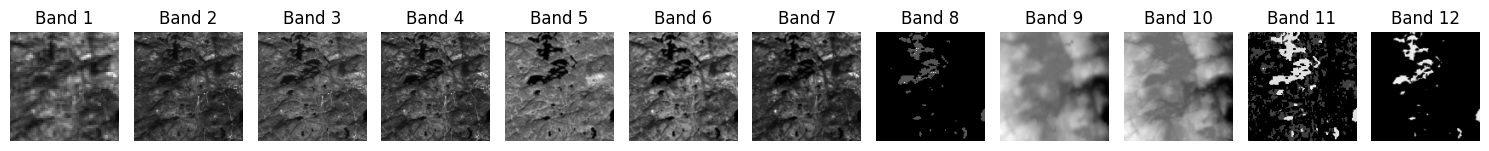

In [20]:
num_bands = img.shape[-1]

fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))

for i in range(num_bands):
    axes[i].imshow(img[:, :, i], cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [5]:
import os
import tifffile as tiff
import tensorflow as tf
import numpy as np

# Initialize lists to hold images and labels
images = []
labels = []
# Load and preprocess images and labels
for filename in os.listdir(images_path):
    if filename.endswith('.tif'):  # For .tif images
        # Load and preprocess image using tifffile
        image = tiff.imread(os.path.join(images_path, filename))
        image = tf.image.resize(image, [128, 128])
        image = image / 65535.0  # Normalize to [0, 1] (assuming 16-bit images)

        # Load and preprocess corresponding label
        label_filename = filename.replace('.tif', '.png')  # Adjust extension for the label
        label = tf.io.read_file(os.path.join(labels_path, label_filename))
        label = tf.image.decode_png(label, channels=1)  # Decode label as grayscale
        label = tf.image.resize(label, [128, 128])  # Resize to match the image
        label = tf.cast(label, tf.int32)  # Convert label to integer type

        # Append to lists
        images.append(image)
        labels.append(label)

# Convert lists to TensorFlow tensors
images = tf.convert_to_tensor(np.array(images))
labels = tf.convert_to_tensor(np.array(labels))

# Assign each image to its corresponding label in a variable called training_data
training_data = tf.data.Dataset.from_tensor_slices((images, labels))



training_data = tf.data.Dataset.from_tensor_slices((images, labels))


Image shape: (128, 128, 12)
Label shape: (128, 128, 1)


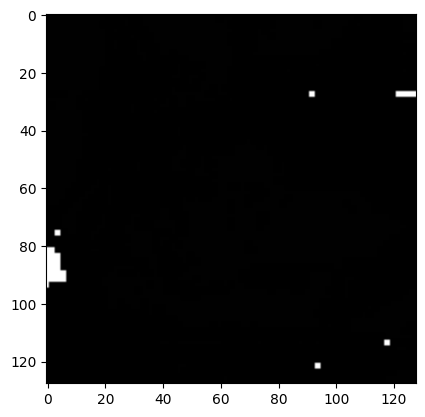

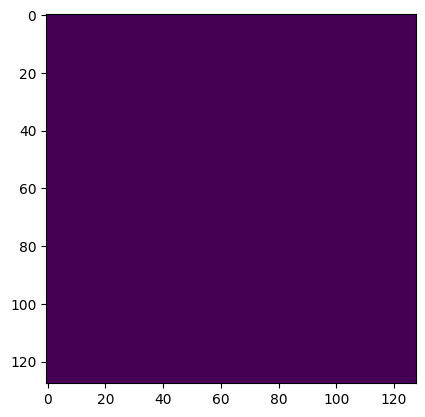

In [32]:
#plot from training_data
for image, label in training_data.take(1):
    plt.imshow(image)
    plt.show()
    plt.imshow(label)
    plt.show()

# Image segmentation

In [6]:
def unet_model(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model



In [7]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    assert train_split + val_split + test_split == 1

    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

train_data, val_data, test_data = split_dataset(training_data)


In [8]:
input_shape = (128, 128, 12)
model = unet_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [11]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
]

In [13]:
model_history = model.fit(
                            train_data.batch(32),
                            validation_data=val_data.batch(32),
                            epochs=30,
                            callbacks=callbacks
                            )


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.9253 - loss: 0.1723 - val_accuracy: 0.9011 - val_loss: 0.2217 - learning_rate: 1.0000e-05
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.9257 - loss: 0.1719 - val_accuracy: 0.9015 - val_loss: 0.2214 - learning_rate: 1.0000e-05
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.9259 - loss: 0.1717 - val_accuracy: 0.9014 - val_loss: 0.2217 - learning_rate: 1.0000e-05
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.9260 - loss: 0.1715 - val_accuracy: 0.9016 - val_loss: 0.2215 - learning_rate: 1.0000e-05
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.9261 - loss: 0.1713 - val_accuracy: 0.9017 - val_loss: 0.2213 - learning_rate: 1.0000e-05
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.9263 - loss: 0.1712 - val_accuracy: 0.9017 - val_loss: 0.2214 - learning_rate: 1.0000e-05
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9264 - loss:

In [14]:
model.evaluate(test_data.batch(32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9385 - loss: 0.1464


[0.1463909149169922, 0.9384746551513672]

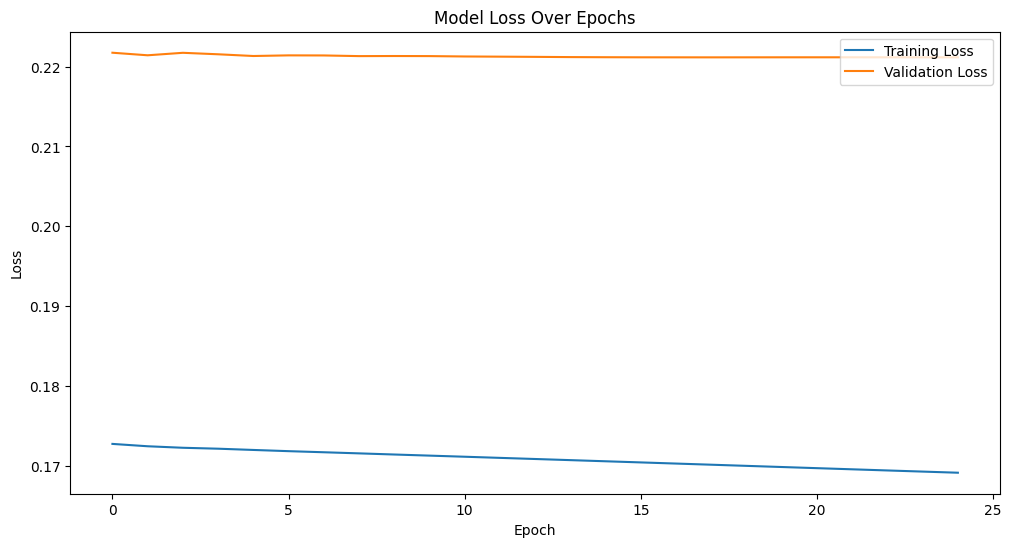

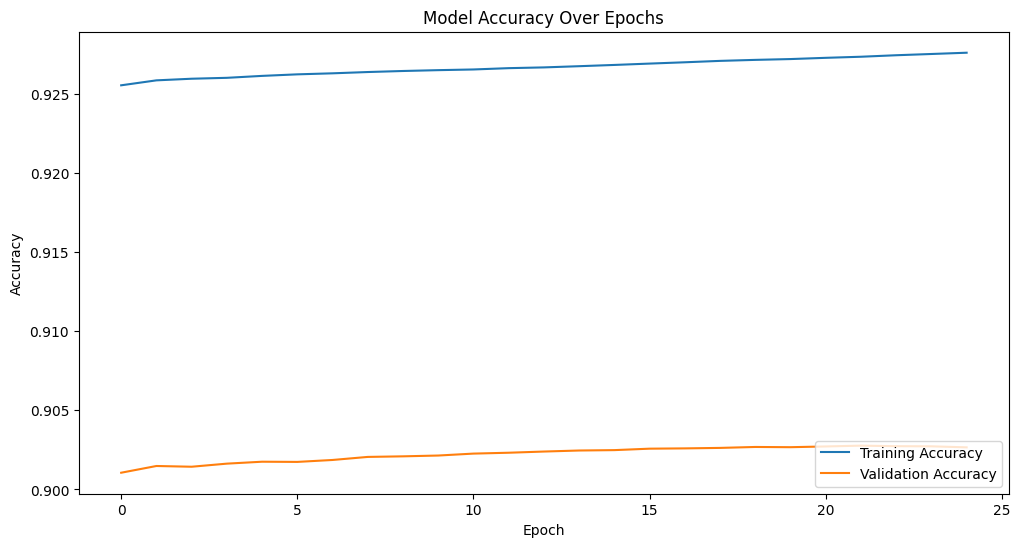

In [16]:
#plot accuracy and loss
  # Plot loss for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['loss'] , label='Training Loss')
plt.plot(model_history.history['val_loss'] , label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy for both phases
plt.figure(figsize=(12, 6))
plt.plot(model_history.history['accuracy'] , label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'] , label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
